In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import string
from os.path import join 
import os
import pickle
import pandas as pd

%matplotlib inline

DATA = 'transcripts'


data = pd.read_pickle(join(DATA,"dtm.pkl"))
data = data.transpose()


In [2]:
# Find the top 30 words
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))


# Print the top 15 words said by each author
for author, top_words in top_dict.items():
    print(author)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')


# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Let's first pull out the top 30 words for each author
words = []
for author in data.columns:
    top = [word for (word, count) in top_dict[author]]
    for t in top:
        words.append(t)

Bowt
перемена, хотеть, это, дело, система, самый, наш, политический, число, общество, мочь, понимать, человек, государство
---
Mlshtn
голунов, суд, дело, иван, который, расследование, журналист, анекдот, весь, это, свой, конец, заниматься, обложка
---
Kuval
это, россия, соколов, современный, российский, лишь, контроль, конец, свой, человек, преподаватель, иметь, вызывать, историк
---
Dvdv
это, весь, человек, который, история, кекс, девочка, страсть, комитет, театр, родительский, государственный, стол, правильный
---
Prav
юрий, реконструкция, парк, патриот, человек, это, весь, говорить, деревня, удовольствие, год, красноармеец, который, мир
---
Mrz
процент, казнь, смертный, сторонник, поддерживать, убийство, россиянин, доля, заявлять, среди, число, мнение, выступать, опрашивать
---
Znam
зал, прокурор, весь, это, судья, заключение, резниченко, подсудимый, ощущение, команда, дверь, обвинительный, минута, распахиваться
---
Mikol
тайга, год, удэгеец, который, день, становиться, река, яр, кр

In [3]:
add_stop_words = [word for word, count in Counter(words).most_common() if count > 2]

from nltk.corpus import stopwords
stopwords_russian = set(stopwords.words("russian")+add_stop_words)

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words=stopwords_russian)

data_clean = pd.read_pickle(join(DATA,"clean.pkl"))
data_cv = cv.fit_transform(data_clean.text)

data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

data_dtm.index = data_clean.index

# Save data 
data_dtm.to_pickle(join(DATA,"dtm_stop.pkl"))
pickle.dump(cv, open(join(DATA,"cv_stop.pkl"), "wb"))

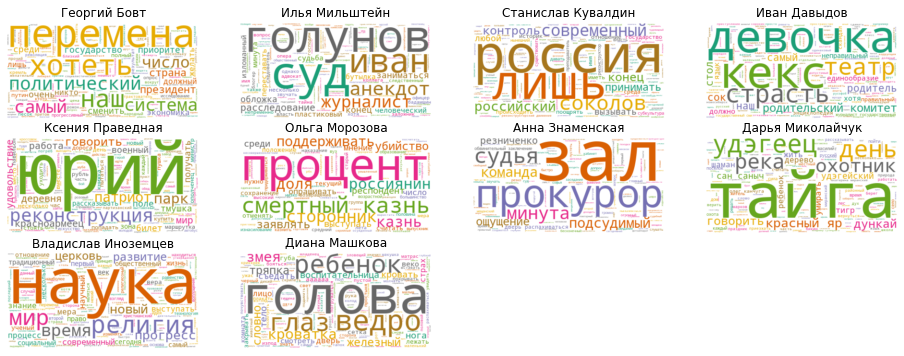

In [4]:
# Let's make some word clouds!
# Terminal / Anaconda Prompt: conda install -c conda-forge wordcloud
from wordcloud import WordCloud

wc = WordCloud(stopwords=stopwords_russian, 
                background_color="white", 
                colormap="Dark2", 
                max_font_size=150, 
                random_state=42)


import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 6]

full_names = list(data_clean.full_name)


# Create subplots for each author
for index, author in enumerate(data.columns):
    wc.generate(data_clean.text[author])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[index])
    

/home/sergio/miniconda3/envs/tensorflow2/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  after removing the cwd from sys.path.


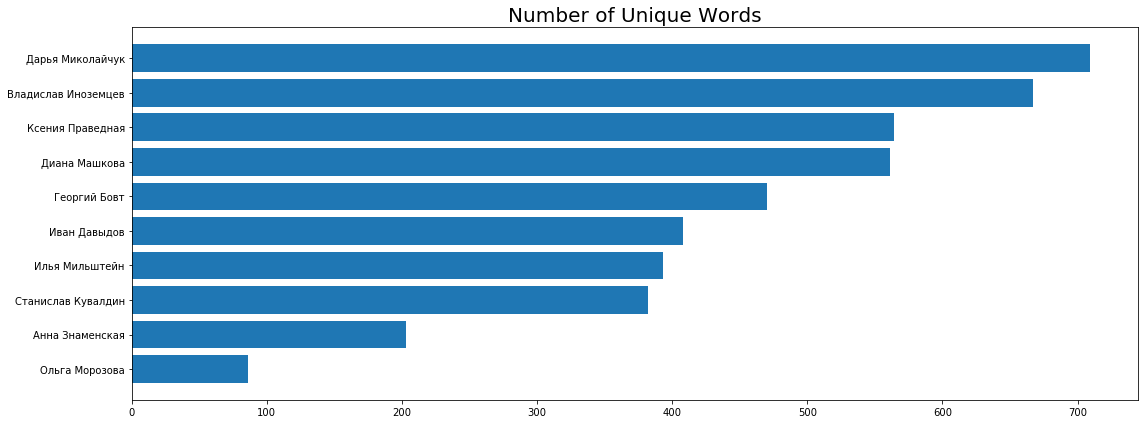

In [5]:


# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for author in data.columns:
    uniques = data[author].nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(full_names, unique_list)), columns=['author', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')
#data_unique_sort


# Let's plot our findings
import numpy as np

y_pos = np.arange(len(data_words))

plt.subplot(1, 1, 1)
plt.barh(y_pos, data_unique_sort.unique_words, align='center')
plt.yticks(y_pos, data_unique_sort.author)
plt.title('Number of Unique Words', fontsize=20)


plt.tight_layout()
plt.show()
